In [2]:
import numpy as np
import matplotlib.pyplot as plt

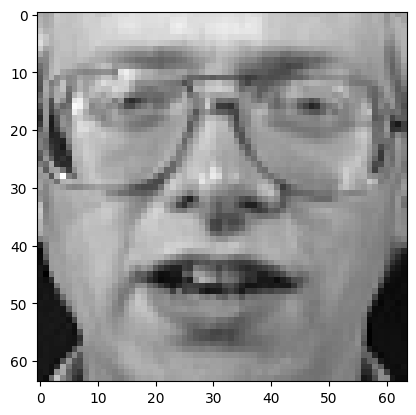

In [3]:
faces = np.load('olivetti_faces.npy')

plt.imshow(faces[16], cmap="gray")

In [4]:
#Faces are in group of 10 corresponding to one person
#We will use 7 images for training and 3 for testing

train_faces = np.zeros((280, 64, 64))
test_faces = np.zeros((120, 64, 64))

np.random.seed(12038)

for i in range(40):
    person_faces = np.copy(faces[i*10:(i+1)*10])
    np.random.shuffle(person_faces)
    train_faces[i*7:(i+1)*7] = person_faces[:7]
    test_faces[i*3:(i+1)*3] = person_faces[7:]
    
train_faces.shape, test_faces.shape

((280, 64, 64), (120, 64, 64))

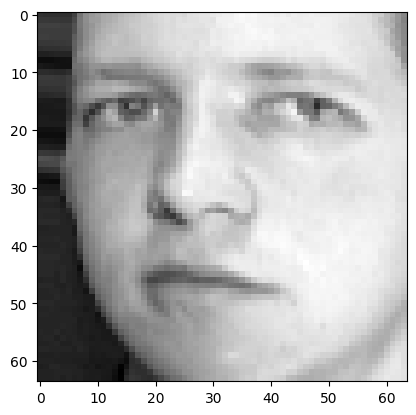

In [5]:
plt.imshow(train_faces[0], cmap='gray')

In [6]:
def flatten_faces(faces):
	return faces.reshape(-1, 4096).T

In [7]:
flattened_train = flatten_faces(train_faces)
flattened_train.shape

(4096, 280)

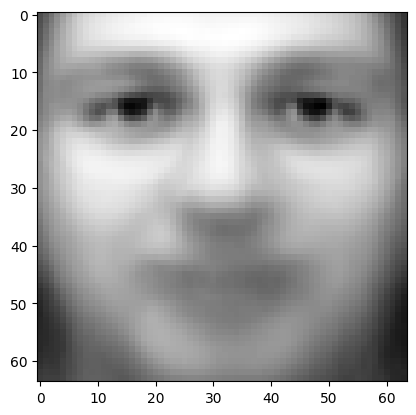

In [8]:
mean_face = flattened_train.mean(axis=1)
plt.imshow(mean_face.reshape(64, 64), cmap="gray")

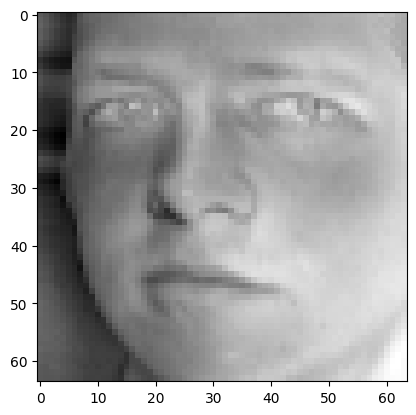

In [9]:
train_set = flattened_train - mean_face[:, None]
plt.imshow(train_set[:, 0].reshape(64, 64), cmap="gray")

In [10]:
U, S, V = np.linalg.svd(train_set, full_matrices=False)

In [11]:
eigenvalues = (S**2)/train_set.shape[1]
eigenvectors = U

In [12]:
eigenvalues.shape, eigenvectors.shape

((280,), (4096, 280))

In [13]:
cums = np.cumsum(eigenvalues)/np.sum(eigenvalues)
len(cums[cums<0.95])

104

In [14]:
eigenfaces = eigenvectors.reshape(64, 64, -1)

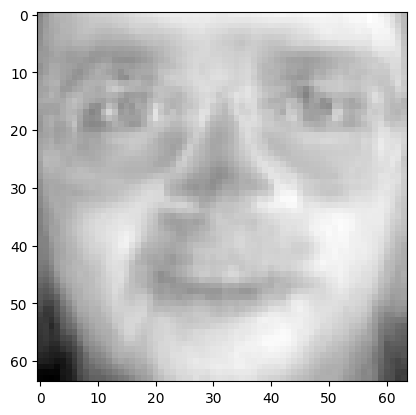

In [15]:
plt.imshow(eigenfaces[:, :, 0], cmap='gray')

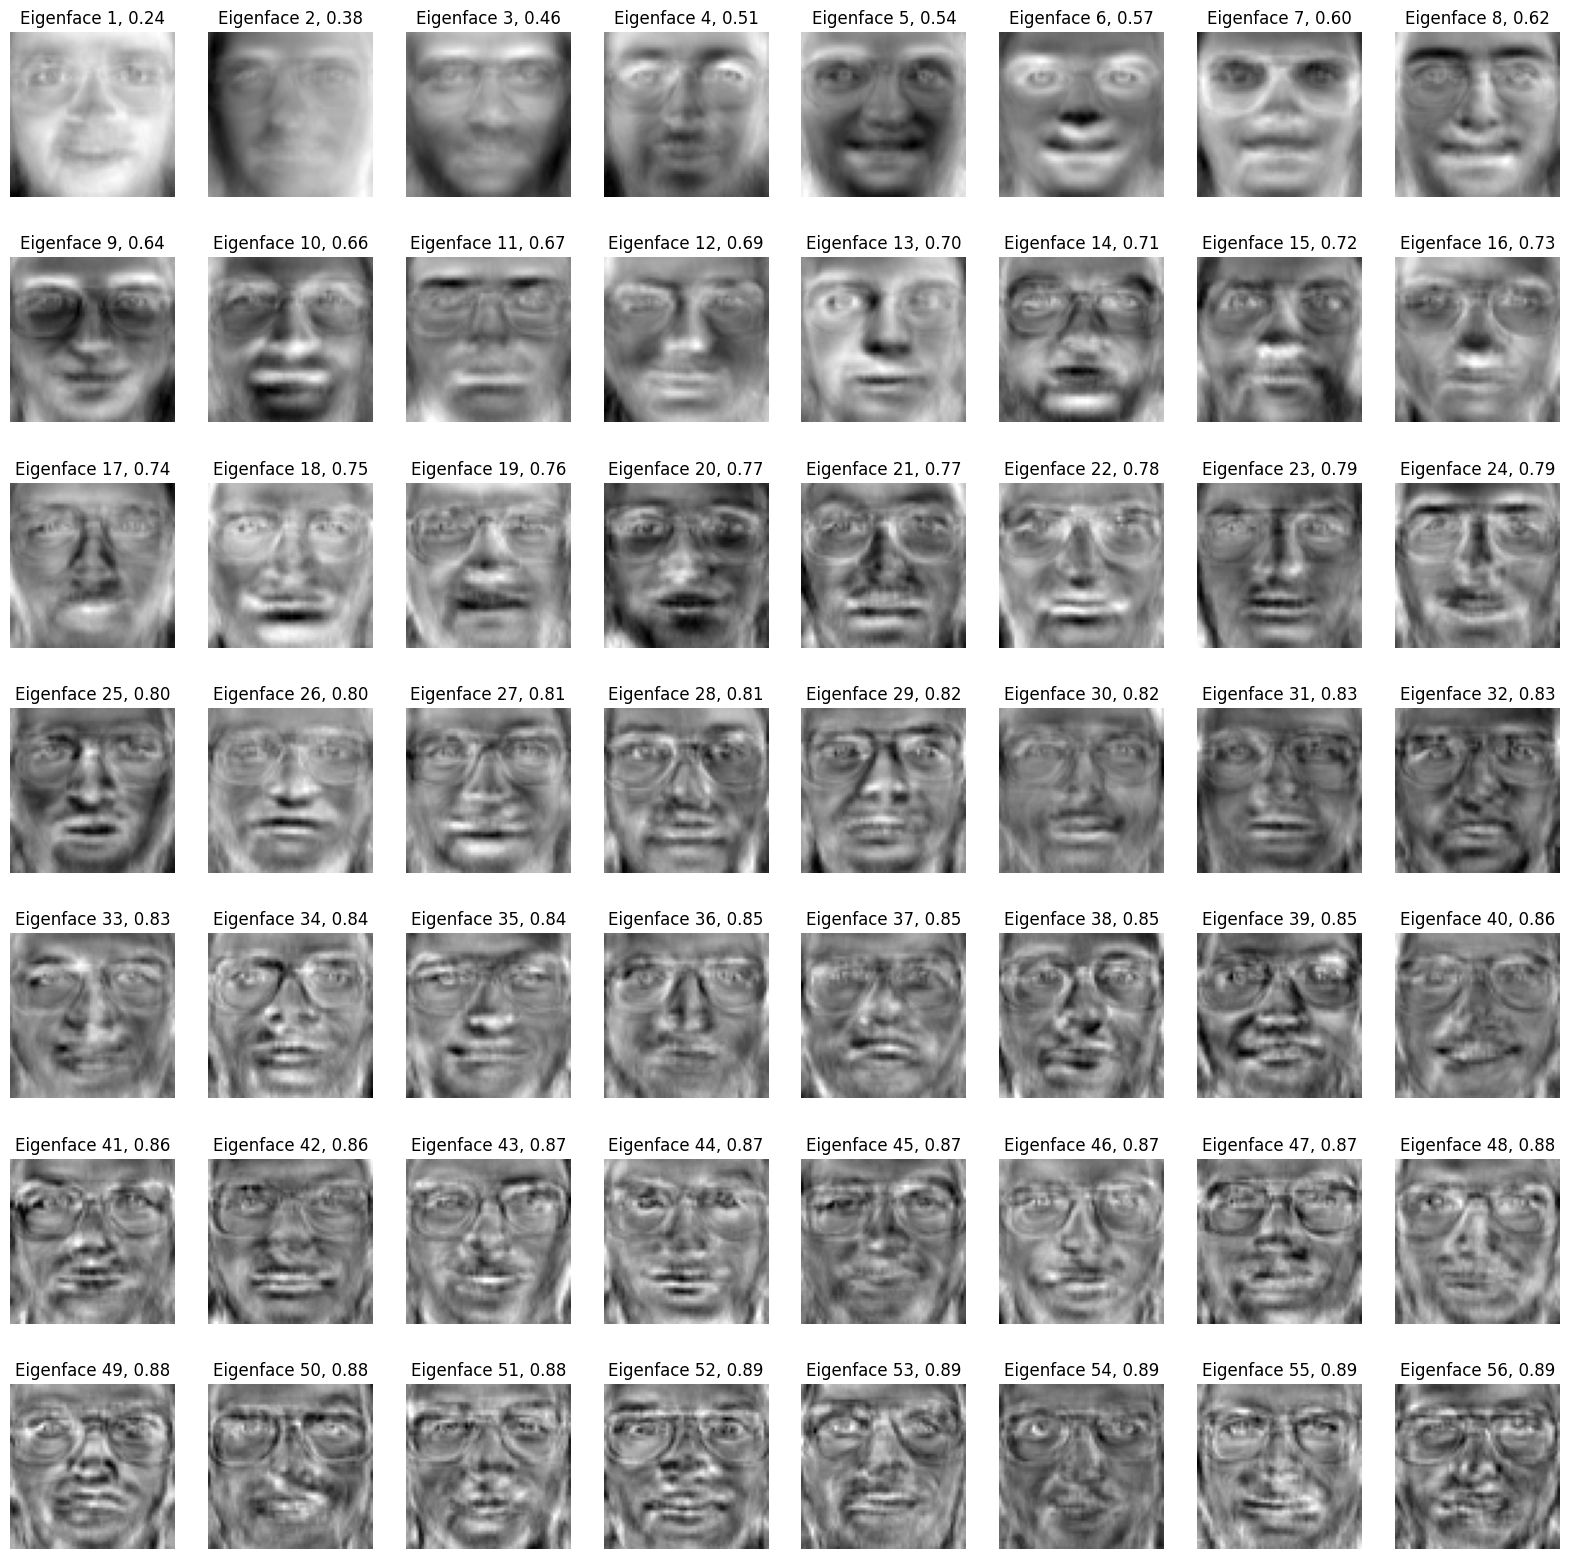

In [16]:
fig, axes = plt.subplots(7, 8, figsize=(20, 20))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(eigenfaces[:, :, i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Eigenface {i+1}, {cums[i]:.2f}')

In [17]:
#Project face

def project_face(face, eigenfaces, mean_face, num_components):
    face = face - mean_face
    weights = np.dot(face, eigenfaces[:, :num_components])
    return weights

def reconstruct_face(weights, eigenfaces, mean_face):
    num_components = weights.shape[0]
    face = np.dot(weights, eigenfaces[:, :num_components].T)
    face = face + mean_face
    return face

In [234]:
face = train_faces[0]
comps = 250

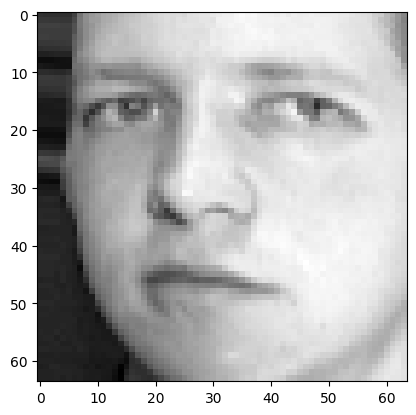

In [235]:
plt.imshow(face, cmap='gray')

In [236]:
print(eigenvectors.shape)

(4096, 280)


In [237]:
weights = project_face(face.flatten(), eigenvectors, mean_face, comps)
weights.shape

(250,)

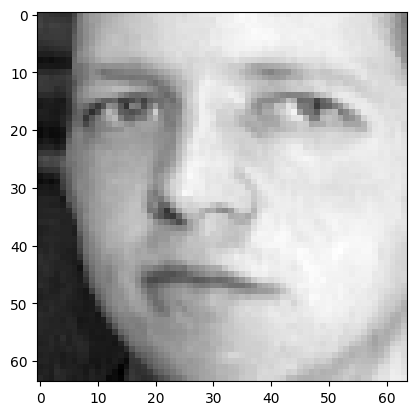

In [238]:
reconstructed_face = reconstruct_face(weights, eigenvectors, mean_face)
reconstructed_face = reconstructed_face.reshape(64, 64)
plt.imshow(reconstructed_face, cmap='gray')

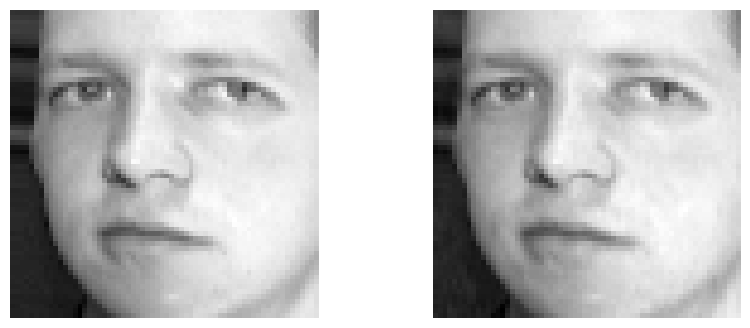

In [239]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.axis("off")
ax2.axis("off")

ax1.imshow(face, cmap="gray")
ax2.imshow(reconstructed_face, cmap="gray")

## Reconstruction

In [23]:
print(eigenvectors.shape)

(4096, 280)


In [33]:
def embed_faces(faces, mean_face, eigenvectors, components=104):
	faces = flatten_faces(faces) - mean_face[:, None]
	
	return np.matmul(faces.T, eigenvectors[:, :components])

In [37]:
def reconstruct_batch(faces, mean_face, eigenvectors, components=104):
	weights = embed_faces(faces, mean_face, eigenvectors, components)
	recon_faces = np.matmul(weights, eigenvectors[:, :components].T) + mean_face[None, :]

	return recon_faces

In [38]:
train_faces.shape

(280, 64, 64)

In [231]:
components = 250

### Train Set

In [232]:
reconstructed_train = reconstruct_batch(train_faces, mean_face, eigenvectors, components)
recon_faces = reconstructed_train.reshape(-1, 64, 64)

valid_mask = train_faces != 0

train_absrel = np.mean(np.abs(recon_faces[valid_mask] - train_faces[valid_mask]) / train_faces[valid_mask])
train_mse = np.mean((recon_faces - train_faces)**2)
train_absrel, train_mse


(np.float64(0.009957456064305233), np.float64(4.434464958368041e-05))

### Test Set

In [233]:
reconstructed_test = reconstruct_batch(test_faces, mean_face, eigenvectors, components)
recon_faces = reconstructed_test.reshape(-1, 64, 64)

valid_mask = test_faces != 0

test_absrel = np.mean(np.abs(recon_faces[valid_mask] - test_faces[valid_mask]) / test_faces[valid_mask])
test_mse = np.mean((recon_faces - test_faces)**2)
test_absrel, test_mse

(np.float64(0.0712576603190827), np.float64(0.001786848884984589))

## Recognition

In [300]:
components = 104

In [302]:
face_db = embed_faces(train_faces, mean_face, eigenvectors, components)
face_db.shape

(280, 104)

In [303]:
def find_closest_faces(faces, face_db, mean_face, eigenvectors):
	components = face_db.shape[1]
	weights = embed_faces(faces, mean_face, eigenvectors, components)
	dots = np.matmul(weights, face_db.T)

	return np.argsort(-dots, axis=1,)

### Test Set

In [330]:
preds = find_closest_faces(test_faces, face_db, mean_face, eigenvectors)[:, 0] // 7
gts = np.arange(40).repeat(3)

np.count_nonzero(preds == gts) /  gts.shape[0]

0.675

In [317]:
closest_to_10 = find_closest_faces(test_faces, face_db, mean_face, eigenvectors)[10, 0:3]

In [318]:
closest_to_10

array([40, 39, 53])

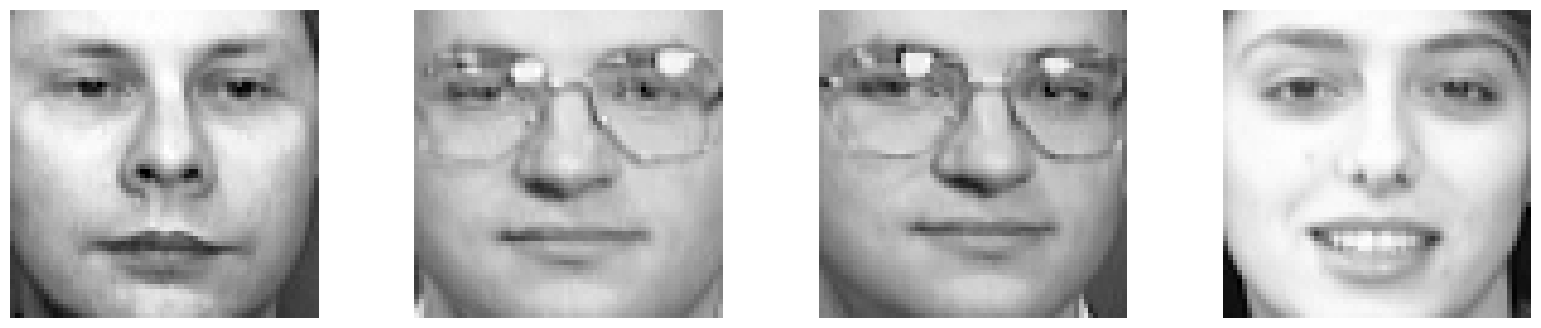

In [325]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for ax in axs:
	ax.axis("off")

for i, ax in enumerate(axs):
	if i == 0:
		ax.imshow(test_faces[10], cmap="gray")
	else:
		ax.imshow(train_faces[closest_to_10[i - 1]], cmap="gray")

### Train Set

In [296]:
preds = find_closest_faces(train_faces, face_db, mean_face, eigenvectors)[:, 0] // 7
gts = np.arange(40).repeat(7)

np.count_nonzero(preds == gts) /  gts.shape[0]

0.95